Esta fase de la metdologia consiste en extraer el valor de los datos desarrollando un modelo que aprenda de los patrones en los datos.

* El diagrama en cuestion de esta fase esta a continuacion:

![Imagen_mapa](imagen_modelado_general.png)

### Selección de tecnicas de Modelado

Al tratarse de un problema de clasificacion de imagenes entre los posibles candidatos tenemos:

* MultiLayer Pereptron: Red neuronal de capas densamente conectadas
* Convolutional Neuronal Network: Red neuronal convolucional.
* Modelos de machine learning clasico (Maquinas de soporte vectorial, arboles de decision e impulso, etc.)

Escogi la red neuronal convolucional porque **aprende de patrones locales** como rasgos pequeños y en bloques de informacion, mientras que el **MLP** aprende de patrones especficos, e decir de todo el espacio de entrada en general.


### Construcción de la arquitectura del modelo

* Para la construccion de la arquitectura aplicaremos Transfer Learning de la arquitectura **MobileNETV2** y la acomplaremos anuestras capas personalizadas para el problema.


![imagen_acoplamiento](imagen_modelado_construccion.png)

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

* Implementamos la arquitectura de MobileNet V2, por ser liviana y consumir menos recursos.

In [3]:
INPUT_SHAPE=(256,256,3) #256x256  pixeles, y 3 canales de colores(R,G,B)

model_mobilenetv2=tf.keras.applications.MobileNetV2(
                                            input_shape=INPUT_SHAPE,
                                            weights="imagenet", #obtener los pesos del entrenamiento con las imagenes ImageNetV3
                                            include_top=False, #no obtener el clasificador final (LO PERSONALIZAMOS),
                                )

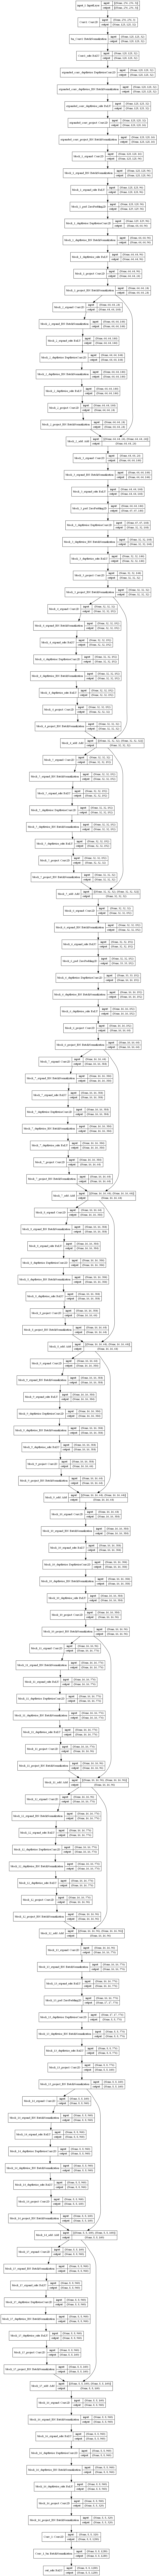

In [4]:
plot_model(model_mobilenetv2,show_shapes=True)

### Arquitectura del modelo adaptado

* Capa de entrada **Input** para las imagenes.
* Capa de Modelo **MobileNetv2** para hacer **Transfer Learning**.
* Capa MaxAveragePooling.
* Capa Densa personalizada que responda a las clases a predecir.

Para esta implementacion usaremos la **API Functional**.

In [5]:
N_CLASSES=4 #Clases a predecir ->COV
BASE_LEARNING_RATE=0.0001
def build_model_base():
    model_mobilenetv2.trainable=False #las capas del modelo no actualizan su peso.
    inputs=tf.keras.layers.Input(shape=INPUT_SHAPE)
    x=model_mobilenetv2(inputs)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs=tf.keras.layers.Dense(units=N_CLASSES,activation="softmax")(x)
    
    model=tf.keras.Model(inputs,outputs)
    
    #compilamos el modelo
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE),
                  metrics=["accuracy",tf.keras.metrics.Recall()]
                  )
    return model

In [6]:
model_base=build_model_base()
model_base.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


* Carga y aumento de datos

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generator de imagenes

* Configuracion del generador de datasets de entrenamiento, validacion y prueba

In [8]:
train_datagen=ImageDataGenerator(
            rescale=1.0/127.5, #escalamos los datos en rangos de [-1,1] El modelo espera esta configuracion
            zoom_range=0.2, #agregamos rotacion a las imagenes
            rotation_range=5,
            horizontal_flip=True
        )
#sobre los datos de validacion y test no se hace ningun aumento de datos.
validation_datagen=ImageDataGenerator(rescale=1.0/127.5) #escalamiento de validacion a un rango de [-1,1]
test_datagen=ImageDataGenerator(rescale=1.0/127.5)       #escalamiento de test a un rango de [-1,1]

* Obtencion de los datos para generar

In [9]:
#definimos las rutas para el acceso a los datos
train_path="../Datasets/train/"
validation_path="../Datasets/val/"
test_path="../Datasets/test/"

#creamos los generadores de datos a partir de los flujos de informacion
BATCH_SIZE=32 #tamaño del lote que se ira pasando poco a poco
IMAGE_SIZE=(256,256)

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator=train_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator=train_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15238 images belonging to 4 classes.
Found 1694 images belonging to 4 classes.
Found 4233 images belonging to 4 classes.


* Generando **Callbacks** para detener el entrenamiento cuando no se tienen buenos resultados


In [12]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3) #cuando la funcion de perdida ya no mejora
n_epochs=10

### Entrenamiento el modelo BASE


In [10]:
model_base=build_model_base()
model_history=model_base.fit_generator(
                    train_generator,
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//BATCH_SIZE,
                    callbacks=[early_stopping]
            )

C:\Users\avira\anaconda3\envs\mlearning\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
477/477 [==============================] - 839s 2s/step - loss: 1.0436 - accuracy: 0.5648 - recall_1: 0.3902 - val_loss: 0.6909 - val_accuracy: 0.7302 - val_recall_1: 0.6382
Epoch 2/10
477/477 [==============================] - 748s 2s/step - loss: 0.6853 - accuracy: 0.7348 - recall_1: 0.6481 - val_loss: 0.6096 - val_accuracy: 0.7668 - val_recall_1: 0.7067
Epoch 3/10
477/477 [==============================] - 738s 2s/step - loss: 0.6108 - accuracy: 0.7637 - recall_1: 0.6996 - val_loss: 0.5683 - val_accuracy: 0.7794 - val_recall_1: 0.7260
Epoch 4/10
477/477 [==============================] - 719s 2s/step - loss: 0.5620 - accuracy: 0.7862 - recall_1: 0.7325 - val_loss: 0.5445 - val_accuracy: 0.7951 - val_recall_1: 0.7404
Epoch 5/10
477/477 [==============================] - 734s 2s/step - loss: 0.5310 - accuracy: 0.7994 - recall_1: 0.7484 - val_loss: 0.5321 - val_accuracy: 0.7993 - val_recall_1: 0.7452
Epoch 6/10
477/477 [==============================] - 721s 2s/step - loss: 

In [16]:
#deseo guardar el History devuelto del entrenamiento
dfhist=pd.DataFrame(model_history.history)
dfhist.to_csv("model_historyV1.csv",index=False)

Mostramos los resultados encontrados

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_results(history,columns=[],ax=None):
    if ax is None:
        fig,(ax)=plt.subplots(1,1)
    df=pd.DataFrame(history)[columns]
    df.plot(kind="line",ax=ax,style="o-")
    ax.set_title(" VS ".join(columns))

Trazamos la curva de la accuracy y funcion de perdida

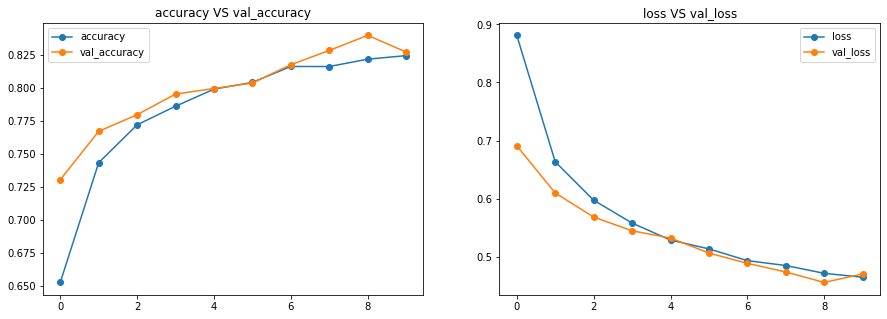

In [32]:
#la curva de precision
history=model_history.history
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_results(history,["accuracy","val_accuracy"],ax=ax1)
plot_results(history,["loss","val_loss"],ax=ax2)
#plt.title("Accuracy & Loss function evolution")
plt.show()

* Para **recall**

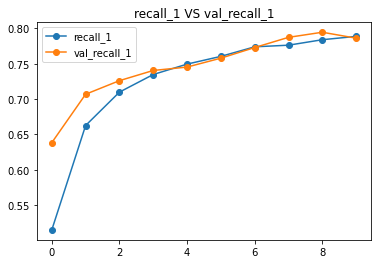

In [34]:
plot_results(history,["recall_1","val_recall_1"])

In [38]:
#guardamos el modelo base con 10 epochs
tf.saved_model.save(model_base,"baseline")
model_base.save("baseline.h5")

INFO:tensorflow:Assets written to: baseline\assets


#### 2da fase del entrenamiento (2/3)

In [10]:
#sesion de entramiento restaurada
#El primer entramiento tuvo solo 10 epocas, por temas de tiempo
#El 2do entrenamiento retoma los datos y establece 10 epocas mas, dando lugar asi a 20 epocas en total.
model_base=tf.keras.models.load_model("baseline.h5")

In [14]:
n_epochs=20
model_base.fit_generator(
        train_generator,
        epochs=n_epochs,
        initial_epoch=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//BATCH_SIZE,
        callbacks=[early_stopping]
    )

C:\Users\avira\anaconda3\envs\mlearning\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 11/20
477/477 [==============================] - 733s 2s/step - loss: 0.4540 - accuracy: 0.8288 - recall_1: 0.7958 - val_loss: 0.4646 - val_accuracy: 0.8317 - val_recall_1: 0.7903
Epoch 12/20
477/477 [==============================] - 793s 2s/step - loss: 0.4459 - accuracy: 0.8324 - recall_1: 0.8012 - val_loss: 0.4575 - val_accuracy: 0.8167 - val_recall_1: 0.7885
Epoch 13/20
477/477 [==============================] - 823s 2s/step - loss: 0.4431 - accuracy: 0.8353 - recall_1: 0.8025 - val_loss: 0.4471 - val_accuracy: 0.8431 - val_recall_1: 0.8077
Epoch 14/20
477/477 [==============================] - 873s 2s/step - loss: 0.4371 - accuracy: 0.8350 - recall_1: 0.8033 - val_loss: 0.4470 - val_accuracy: 0.8389 - val_recall_1: 0.8035
Epoch 15/20
477/477 [==============================] - 874s 2s/step - loss: 0.4299 - accuracy: 0.8394 - recall_1: 0.8098 - val_loss: 0.4514 - val_accuracy: 0.8269 - val_recall_1: 0.7981
Epoch 16/20
477/477 [==============================] - 850s 2s/step - 

In [17]:
import pandas as pd
#deseo guardar el History devuelto del entrenamiento
model_history=_
dfhist=pd.DataFrame(model_history.history)
dfhist.to_csv("model_historyV2.csv",index=False)

* Graficar las dos sesiones de entrenamiento

In [18]:
df1=pd.read_csv("model_historyV1.csv",sep=",")
df2=pd.read_csv("model_historyV2.csv",sep=",")
df_history=pd.concat([df1,df2],axis=0)

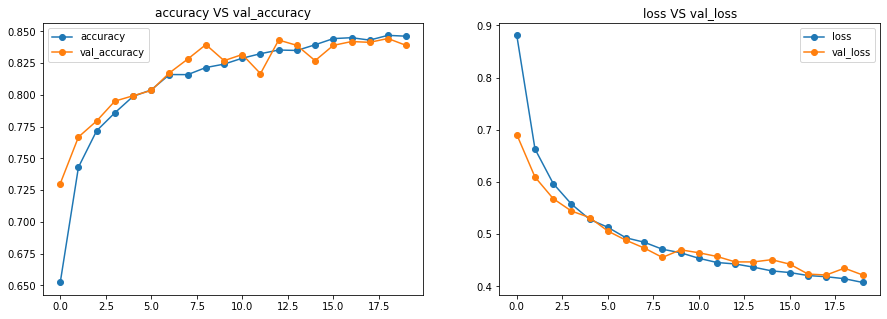

In [21]:
#la curva de precision
history=df_history.to_dict("list")
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_results(history,["accuracy","val_accuracy"],ax=ax1)
plot_results(history,["loss","val_loss"],ax=ax2)
#plt.title("Accuracy & Loss function evolution")
plt.show()

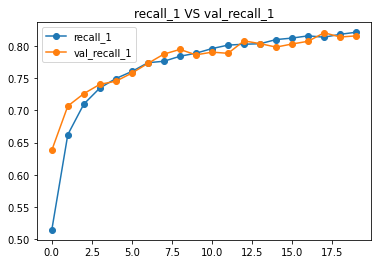

In [22]:
plot_results(history,["recall_1","val_recall_1"])

* Guardamos el modelo base final. sesion (2/3)

In [23]:
model_base.save("baselinev2.h5")

* Evaluamos el puntaje en el **conjunto de entrenamiento**.

In [24]:
model_base.evaluate(train_generator)

477/477 [==============================] - 650s 1s/step - loss: 0.4047 - accuracy: 0.8498 - recall_1: 0.8218


[0.40467602014541626, 0.8498490452766418, 0.8217613697052002]

* Evaluamos el puntaje en el **conjunto de validacion**.

In [25]:
model_base.evaluate(validation_generator)

53/53 [==============================] - 77s 1s/step - loss: 0.4248 - accuracy: 0.8430 - recall_1: 0.8117


[0.42475569248199463, 0.8429751992225647, 0.8116883039474487]

* **RESULTADOS PARCIALES**: 

El accuracy para el conjunto de entrenamiento es de **ACC=84.98%** y **Recall=82.18%**.

El accuracy para el conjunto de validación es de **ACC=84.29%** y **Recall=81.16%**.

#### 3era fase de entrenamiento (3/3)

* Retomamos el entrenamiento pasado y continuamos el entrenamiento

In [28]:
epochs=30
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3) #cuando la funcion de perdida ya no mejora
BATCH_SIZE=32
model_history=model_base.fit_generator(
                        train_generator,
                        epochs=epochs,
                        initial_epoch=20,
                        validation_data=validation_generator,
                        validation_steps=validation_generator.samples//BATCH_SIZE,
                        callbacks=[early_stopping]
                )

C:\Users\avira\anaconda3\envs\mlearning\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 21/30
477/477 [==============================] - 839s 2s/step - loss: 0.4072 - accuracy: 0.8470 - recall_1: 0.8196 - val_loss: 0.4243 - val_accuracy: 0.8431 - val_recall_1: 0.8083
Epoch 22/30
477/477 [==============================] - 866s 2s/step - loss: 0.4028 - accuracy: 0.8521 - recall_1: 0.8267 - val_loss: 0.4133 - val_accuracy: 0.8450 - val_recall_1: 0.8203
Epoch 23/30
477/477 [==============================] - 849s 2s/step - loss: 0.4043 - accuracy: 0.8512 - recall_1: 0.8255 - val_loss: 0.4106 - val_accuracy: 0.8438 - val_recall_1: 0.8191
Epoch 24/30
477/477 [==============================] - 826s 2s/step - loss: 0.4070 - accuracy: 0.8495 - recall_1: 0.8236 - val_loss: 0.4160 - val_accuracy: 0.8534 - val_recall_1: 0.8233
Epoch 25/30
477/477 [==============================] - 817s 2s/step - loss: 0.3970 - accuracy: 0.8502 - recall_1: 0.8248 - val_loss: 0.4008 - val_accuracy: 0.8468 - val_recall_1: 0.8263
Epoch 26/30
477/477 [==============================] - 904s 2s/step - 

In [29]:
dtf=pd.DataFrame(model_history.history)
dtf.to_csv("model_historyV3.csv",index=False)

* Volvemos a ejecutar la secuencia de pasos de verificacion de resultados

In [30]:
df1=pd.read_csv("model_historyV1.csv",sep=",")
df2=pd.read_csv("model_historyV2.csv",sep=",")
df3=pd.read_csv("model_historyV3.csv",sep=",")
df_history=pd.concat([df1,df2,df3],axis=0)

* Creamos una funcion para reutilizar la funcion que genera el grafico, para los modelos que se porbaran mas adelante.

In [46]:
def plot_metrics(history,metrics=[]): #retorna una lista de tuplas
    fig,axes=plt.subplots(1,len(metrics))
    fig.set_size_inches(15,5)
    graph=pd.DataFrame(history)
    for i,ax in enumerate(axes.flat):
        graph[list(metrics[i])].plot(kind="line",style="o-",ax=ax)
        ax.set_title(" VS ".join(list(metrics[i])))
        ax.grid(True)
    plt.show()

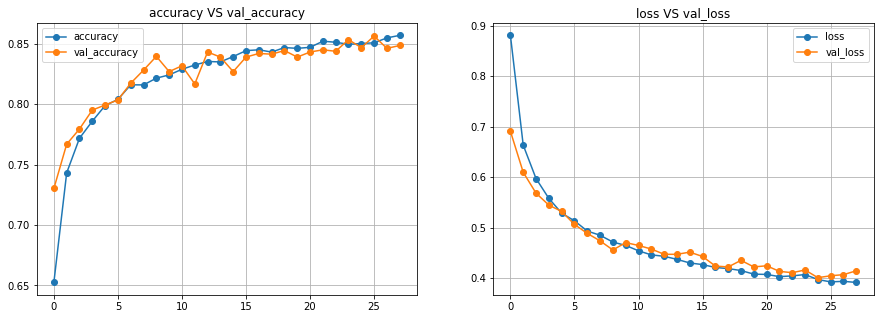

In [47]:
model_history=df_history.to_dict("list")
metrics=[("accuracy","val_accuracy"),("loss","val_loss")]
plot_metrics(model_history,metrics=metrics)

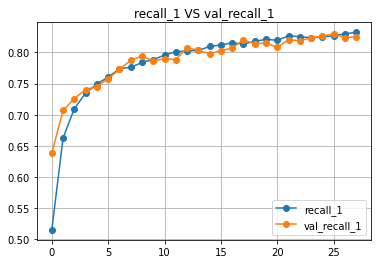

In [43]:
plot_results(model_history,["recall_1","val_recall_1"])
plt.grid(True)


* Guardamos el modelo final (3/3) para validarlo.

In [48]:
model_base.save("baselinev3.h5")

* El entrenamiento del modelo se detuvo en 28 epochs lo que nos dice que la funcion de perdida en la data de validacion no mejoro por 3 epochs consecutivos, probablemente, ya no mejore para futuras epocas.

Ahora veamos el rendiemiento del modelo base en los datos de entrenamiento y validacion

In [52]:
model_base.evaluate(train_generator)

477/477 [==============================] - 704s 1s/step - loss: 0.3878 - accuracy: 0.8566 - recall_1: 0.8322


[0.3877873122692108, 0.8566084504127502, 0.8321958184242249]

In [53]:
model_base.evaluate(validation_generator)

53/53 [==============================] - 81s 2s/step - loss: 0.4038 - accuracy: 0.8512 - recall_1: 0.8253


[0.4038473963737488, 0.8512396812438965, 0.825265645980835]

* Mostramos la matriz de confusion en los datos de entrenamiento y validacion

Para el conjunto de entrenamiento

In [59]:
import numpy as np,seaborn as sns; sns.set()

y_true=train_generator.classes
y_pred=np.argmax(model_base.predict(train_generator),axis=1)

In [66]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

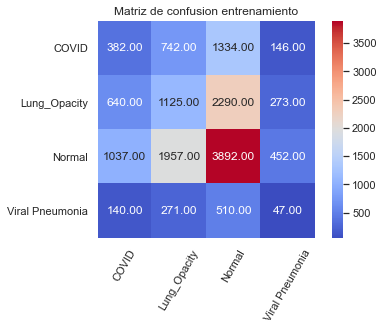

In [76]:
#obtenemos la matriz de confusion de sklearn
from sklearn.metrics import confusion_matrix

classes=train_generator.class_indices.keys()
mat_train=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_train,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion entrenamiento")
plt.show()

* Para el conjunto de validacion

In [77]:
y_true=validation_generator.classes
y_pred=np.argmax(model_base.predict(validation_generator),axis=1)

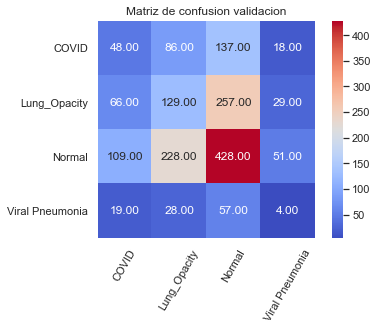

In [78]:
classes=validation_generator.class_indices.keys()
mat_val=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_val,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion validacion")
plt.show()

### RESULTADOS FINALES: MODELO BASE
* El modelo base ha obtenido un puntaje de accuracy **ACC=85.66%** y recall **RECALL=83.22%** en el **conjunto de entrenamiento**.

* El modelo ha obtendio un puntaje de accuracy **ACC=85.12%** y recall **RECALL=82.52%** en el **conjunto de validacion**.

**IMPORTANTE**: El modelo ha alcanzado el equilibrio entre los datos de entrenamiento y validacion, lo que siginifica que es un modelo final con aproximadamente 85% de precision. Este modelo pasará a la **Fase de evaluación del modelo**.

## Mejorar el modelo base: Estrategia Ajuste fino

* Uno de los objetivos de la elaboracion de un modelo base es que los modelos posteriores a este tienen que tener un rendimiento mayor, por lo que esta siguiente implementacion buscara superar al modelo base.

* En el modelo base anterior se un metodo de transferencia de aprendizaje llamado selección de caracteristicas, pero este metodo congelaba la mayor parte de la arquitectura y agregaba unas capas referencias al clasificador de radiografias. Ahora el modelo trata de obtener mayor rendimiento descongelando algunas capas finales del modelo, para que el modelo pueda especializarse mas de los datos de radiografias.